Student name: David Schenck<br>
Student pace: Flex<br>
Scheduled project review date/time:<br>
Instructor Name: Morgan Jones<br>
Blog post URL:

# Project Description

The World Health Organization (WHO) estimates that 2 million children below the age of 5 die from pneumonia every year, making it the leading cause of child mortality worldwide. The vast majority of cases and deaths are in developing countries, particularly in Africa and Southeast Asia.

Timely diagnosis of pneumonia is key for improving health outcomes for patients. It is also important to determine whether the pneumonia is caused by a bacterial or a viral infection since the treatment plans are very different depending on the cause.

One effective method of diagnosing pneumonia is by taking chest X-rays. A medical expert can identify the telltale signs of pneumonia by observing the X-rays, but some facilities in developing countries lack such an expert. This slows down the process of diagnosing the disease, leading to delays in medical intervention.

A potential solution is to create a computer model that can interpret the chest X-rays. Such a model could be made available to medical facilities across the world, helping to shorten the time it takes to diagnose pediatric pneumonia so that life-saving treatment can be provided faster.

In this project, I train a convolutional neural network (CNN) to diagnose pneumonia using a labeled set of chest X-rays.

### Data
The data used in this project was obtained from https://data.mendeley.com/datasets/rscbjbr9sj/3.

The data contains 5856 images of chest X-rays taken for children 5 years of age or younger. The images were examined by 2 medical experts to determine whether the patient has pneumonia and, if so, whether it is bacterial or viral pneumonia. A third expert validated their classifications.

The data is split into train and test directories, and each of those is split into "NORMAL" and "PNEUMONIA" directories. The images corresponding to a patient with bacterial pneumonia all start with "BACTERIA" and those with viral pneumonia start with "VIRUS". Patients without pneumonia all of images starting with "NORMAL".

Below is a breakdown of how many images there are in each directory:

train - NORMAL: 1349<br>
train - PNEUMONIA: 3883 (BACTERIA: 2538, VIRUS: 1345)<br>
test - NORMAL: 234<br>
test - PNEUMONIA: 390 (BACTERIA: 242, VIRUS: 148)

In addition to indicating whether the patient has pneumonia, the filename also includes a unique 6-digit code for each patient and a 4-digit code counting the number of images for that patient since some patients have multiple images. For example, a patient with multiple images will have their first image will end with 0001, second with 0002, and so on.

The images have a variety of dimensions and aspect ratios. They are cropped and resized to a standard size before they are input to the CNN.

Note: The zip file provided at https://data.mendeley.com/datasets/rscbjbr9sj/3 contains data of both chest X-ray images for diagnosing pneumonia and optimal coherence tomography (OCT) images for diagnosing eye conditions. I only use the chest X-ray images.

In [614]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### Data Exploration

First, I just want to see how many images are in each directory

In [251]:
# Count the number of images in each directory
# Main directory
maindir = 'C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/'
# Subdirectories in main directory
subdirs = ['train/NORMAL/','train/PNEUMONIA/','test/NORMAL/','test/PNEUMONIA/']

for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        print(directory, '\t BACTERIA:',sum([1 if 'BACTERIA' in x else 0 for x in files]),
              'VIRUS:', sum([1 if 'VIRUS' in x else 0 for x in files]))
    else:
        print(directory, '\t \t NORMAL:', len(files))

train/NORMAL/ 	 	 NORMAL: 1349
train/PNEUMONIA/ 	 BACTERIA: 2538 VIRUS: 1345
test/NORMAL/ 	 	 NORMAL: 234
test/PNEUMONIA/ 	 BACTERIA: 242 VIRUS: 148


The images have different dimensions and aspect ratios. I will crop and resize the images to a common size. Below, I determine what the average aspect ratio is. I will use this for the final aspect ratio.

In [252]:
names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])] + \
        [os.path.join(maindir+subdirs[1], name) for name in os.listdir(maindir+subdirs[1])] + \
        [os.path.join(maindir+subdirs[2], name) for name in os.listdir(maindir+subdirs[2])] + \
        [os.path.join(maindir+subdirs[3], name) for name in os.listdir(maindir+subdirs[3])]

img_dims = []
for img_path in names:
    if 'jpeg' in img_path:
        img = load_img(img_path, color_mode='grayscale')
        img_dims.append([img.height,img.width])
img_dims = np.array(img_dims)

0.7147827266780963


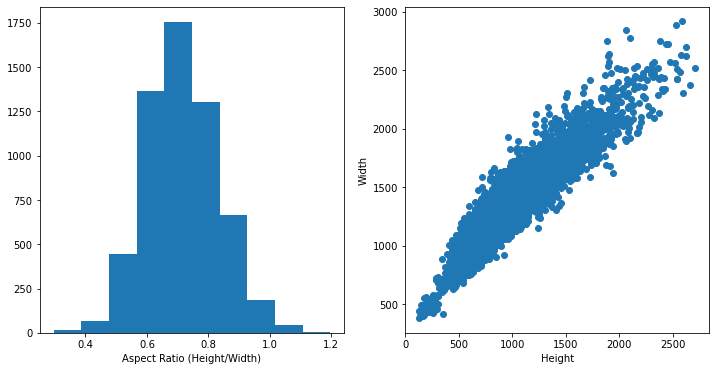

In [254]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

aspect_ratios = img_dims[:,0]/img_dims[:,1]
mean_aspect = np.mean(aspect_ratios)
print(mean_aspect)
ax[0].hist(aspect_ratios)
ax[0].set_xlabel('Aspect Ratio (Height/Width)')
ax[1].scatter(img_dims[:,0],img_dims[:,1])
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Width');

Below, I create a function that will read in an image, crop it, and resize it.

I could just resize without cropping, but this would result in stretching the image either vertically or horizontally. By cropping first, I avoid stretching the images.

The way I crop the images is by checking whether the image is too tall or too wide (compared to the average aspect ratio). If it is too tall, I will crop equal amounts from the top and bottom of the image to achieve the desired aspect ratio. If it is too wide, I crop equal amounts from the left and right. I tested this on a few images and the parts of images that get cut out should not be important for diagnosing pneumonia. The lungs are what matters and they don't get cropped out using the function below.

In [292]:
def crop_resize_image(filepath, dims=None, rescale=None):
    """
    Reads in an image, crops it, and resizes it so that the final array has dimensions dims.
    Input:
    filepath: Full directory path to image.
    dims: Desired dimensions of image as tuple. Default is None, in which case no cropping or resizing is done.
    rescale: Number by which to multiply the image. Default is to not rescale.
    """
    img = load_img(filepath, color_mode='grayscale')
    if dims == None:
        img_array = img_to_array(img)
    # Crop and resize if dims is specified
    else:
        desired_aspect = dims[0]/dims[1]
        if img.height/img.width > desired_aspect:
            desired_height = img.width * desired_aspect
            cut = np.round((img.height - desired_height)/2,0)
            img_crop = img.crop((0,cut,img.width,img.height-cut))
        else:
            desired_width = img.height / desired_aspect
            cut = np.round((img.width - desired_width)/2,0)
            img_crop = img.crop((cut,0,img.width-cut,img.height))
        img_resize = img_crop.resize((dims[1],dims[0]))
        img_array = img_to_array(img_resize)
        
    # Rescale the image if rescale is defined
    if rescale != None:
        img_array *= rescale
        
    return img_array[:,:,0]

In [318]:
# Try out the function above
directory = maindir + subdirs[0]
files = [x for x in os.listdir(directory) if 'jpeg' in x]
# Desired width of images
width = 180
dimensions = (int(np.round(mean_aspect*width,0)), width)
img_array = crop_resize_image(directory+files[6], dimensions, 1/255)
img_array.shape

(129, 180)

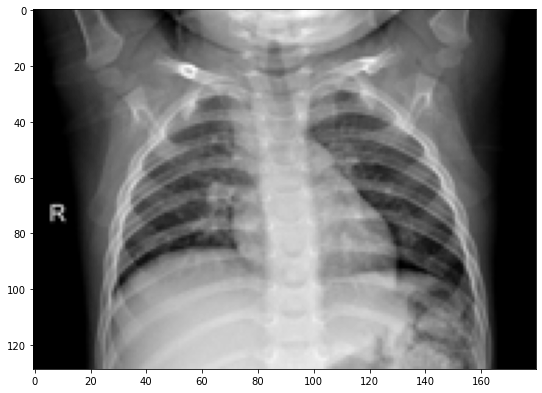

In [319]:
fix, ax = plt.subplots(figsize=(9,9))
ax.imshow(img_array, cmap='gray')

The function below is used to get samples of images. The function allows the user to specify how many images to collect and whether you want one or two samples (useful for creating train and validation splits)

In [546]:
def get_image_filenames(rootdir, subdir, size='all', size2=0):
    """
    This function collects filenames of images.
    Input:
    rootdir: The directory that contains all of the data.
    subdir: Indicates whether to collect images from 'train' or 'test'.
    size: Number of images to collect. Default is collect all the images.
    size2: If indicated, it is the number of images to collect for a second sample.
        This is useful for creating a validation sample which won't overlap with the training sample.2
        
    Output:
    One list of files and one list of labels (if size2=0) or two lists of files and two lists of labels if size2>0.
    """
    # Get image names from NORMAL
    directory = rootdir + subdir + '/NORMAL/'
    files_normal = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    # Get image names from PNEUMONIA
    directory = rootdir + subdir + '/PNEUMONIA/'
    files_pneum = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    files_bacteria = [x for x in files_pneum if 'BACTERIA' in x]
    files_virus = [x for x in files_pneum if 'VIRUS' in x]

    # Check to make sure we did not ask for more files than exist in the directories
    if size != 'all':
        check = (len(files_normal) >= size+size2) * (len(files_bacteria) >= size+size2) * (len(files_virus) >= size+size2)
        if check == False:
            raise Exception('Asked for more images than are actually present')
    
    if size == 'all':
        filenames = np.append(files_normal, np.append(files_bacteria, files_virus))

        return filenames

    else:
        sample_normal = np.random.choice(files_normal, size+size2, replace=False)
        sample_bacteria = np.random.choice(files_bacteria, size+size2, replace=False)
        sample_virus = np.random.choice(files_virus, size+size2, replace=False)
            
        if size2 == 0:
            filenames = np.append(sample_normal, np.append(sample_bacteria, sample_virus))

            return filenames
        else:
            filenames1 = np.append(sample_normal[0:size], np.append(sample_bacteria[0:size],sample_virus[0:size]))
            filenames2 = np.append(sample_normal[size:], np.append(sample_bacteria[size:],sample_virus[size:]))

            return filenames1, filenames2

In [553]:
def create_tensors(filenames, dims, OHE=True):
    """
    Function for turning a list of filenames into tensors that can be input to a CNN model.
    Inputs:
    filenames: List of filenames.
    dims: The desired dimensions of the output.
    OHE: Indicates whether the class labels should be one-hot encoded. Default is True.
    """
    x = np.zeros((len(filenames), dims[0], dims[1]))
    y = np.zeros(len(filenames))
    for n, file in enumerate(filenames):
        x[n] = crop_resize_image(file, dims, 1/255)
        # Determine the class of the image
        if 'NORMAL' in file:
            y[n] = 0
        elif 'BACTERIA' in file:
            y[n] = 1
        elif 'VIRUS' in file:
            y[n] = 2
        else:
            raise Exception(f"Cannot determine class for {file}")
    
    if OHE:
        y = to_categorical(y, 3)
        
    x = x.reshape(-1, dims[0], dims[1], 1)
    return x, y

In [559]:
np.random.seed(42)
train_size = 500
val_size = 100

train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

x_train, y_train = create_tensors(train_list, dimensions, OHE=True)
x_val, y_val = create_tensors(val_list, dimensions, OHE=True)
x_test, y_test = create_tensors(test_list, dimensions, OHE=True)

In [595]:
from keras import models
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### Building a Convolutional Neural Network

I am going to iteratively create a convolutional neural network. In order to evaluate the models, I need to look at some metrics. It will be helfpul to have a function I can call that will display the metrics I care about.

The function below will create and print a classification report and a confusion matrix.

In [625]:
def display_metrics(model, train_data=None, val_data=None, test_data=None):
    """
    Function for displaying classification report and confusion matrix.
    
    Inputs:
    model: The fitted model.
    train_data, val_data, test_data: (x,y) tuple containing different types of data.
    Default is None, in which case no classification report or confusion matrix will be displayed.
    """
    # Classification reports
    
    count = 0
    
    if train_data != None:
        print("Classification Report: Train")
        print(classification_report(np.argmax(train_data[1], axis=-1),
                                    np.argmax(model.predict(train_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS']))
        count += 1
    if val_data != None:
        print("Classification Report: Validation")
        print(classification_report(np.argmax(val_data[1], axis=-1),
                                    np.argmax(model.predict(val_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS']))
        count += 1
    if test_data != None:
        print("Classification Report: Test")
        print(classification_report(np.argmax(test_data[1], axis=-1),
                                    np.argmax(model.predict(test_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS']))
        count += 1
        
    # Confusion Matrices
    fig, ax = plt.subplots(ncols=count, figsize=(count*5,4))
    n = 0
    if train_data != None:
        cf = confusion_matrix(np.argmax(train_data[1], axis=-1), np.argmax(model.predict(train_data[0]), axis=-1))
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Train')
        ax[n].grid(False)
        n += 1
    if val_data != None:
        cf = confusion_matrix(np.argmax(val_data[1], axis=-1), np.argmax(model.predict(val_data[0]), axis=-1))
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Validation')
        ax[n].grid(False)
        n += 1
    if test_data != None:
        cf = confusion_matrix(np.argmax(test_data[1], axis=-1), np.argmax(model.predict(test_data[0]), axis=-1))
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Test')
        ax[n].grid(False)

    fig.tight_layout()
    
    # ROC curves (only test data)
    if test_data != None:
        fig2, ax2 = plt.subplots(figsize=(6,6))
        
        ax2.plot([0,0],[1,1])
        
        for i, case in enumerate(['NORMAL vs. Rest','BACTERIA vs. Rest','VIRUS vs. Rest']):
            fpr, tpr, thresh = roc_curve(test_data[1][:,i], model.predict(test_data[0])[:,i])
            ax2.plot(fpr, tpr, label=f"{case}: {round(auc(fpr, tpr),3)}")
        ax2.set_title('ROC Curve: Test Data')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()

In [560]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 60, 86, 32)        16416     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 28, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 14, 20, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 17920)           

In [563]:
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/50
47/47 [==============================] - 18s 391ms/step - loss: 0.6599 - acc: 0.7027 - val_loss: 0.6525 - val_acc: 0.7233
Epoch 2/50
47/47 [==============================] - 17s 363ms/step - loss: 0.6487 - acc: 0.7187 - val_loss: 0.6935 - val_acc: 0.7100
Epoch 3/50
47/47 [==============================] - 17s 372ms/step - loss: 0.6476 - acc: 0.7127 - val_loss: 0.6374 - val_acc: 0.7433
Epoch 4/50
47/47 [==============================] - 18s 380ms/step - loss: 0.6250 - acc: 0.7273 - val_loss: 0.6539 - val_acc: 0.7367
Epoch 5/50
47/47 [==============================] - 17s 356ms/step - loss: 0.6328 - acc: 0.7087 - val_loss: 0.6095 - val_acc: 0.7533
Epoch 6/50
47/47 [==============================] - 17s 367ms/step - loss: 0.6269 - acc: 0.7247 - val_loss: 0.6158 - val_acc: 0.7433
Epoch 7/50
47/47 [==============================] - 18s 386ms/step - loss: 0.6145 - acc: 0.7273 - val_loss: 0.6347 - val_acc: 0.7467
Epoch 8/50
47/47 [==============================] - 18s 384ms/step - 

Below, I create a function for graphing the loss and accuracy as a function of epoch.

In [530]:
def plot_history(history):
    """
    Function to plot the loss and accuracy vs epoch for a model.
    Input is the history of a model.
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch = range(len(acc))
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax[0].plot(epoch, acc, label='Training')
    ax[0].plot(epoch, val_acc, label='Validation')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(epoch, loss, label='Training')
    ax[1].plot(epoch, val_loss, label='Validation')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

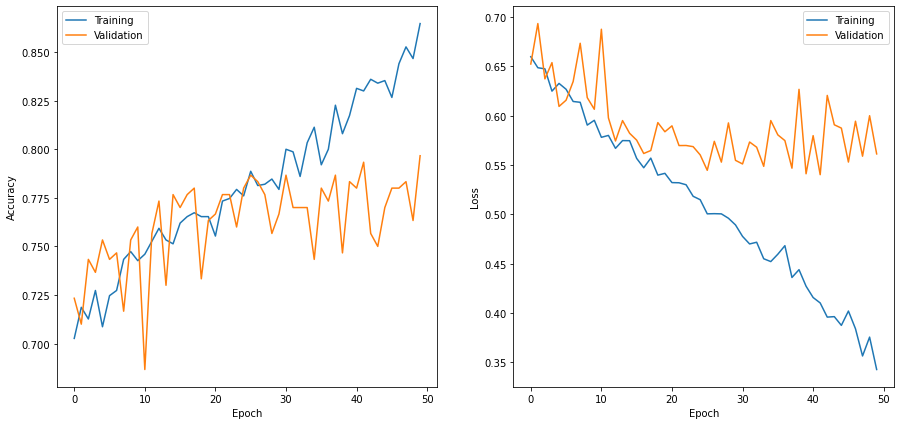

In [566]:
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL       0.95      0.98      0.96       500
    BACTERIA       0.84      0.89      0.86       500
       VIRUS       0.87      0.79      0.83       500

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL       0.88      0.98      0.93       100
    BACTERIA       0.75      0.76      0.75       100
       VIRUS       0.75      0.65      0.70       100

    accuracy                           0.80       300
   macro avg       0.79      0.80      0.79       300
weighted avg       0.79      0.80      0.79       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL       0.92      0.84      0.88       234
    BACTERIA       0.82      0.85     

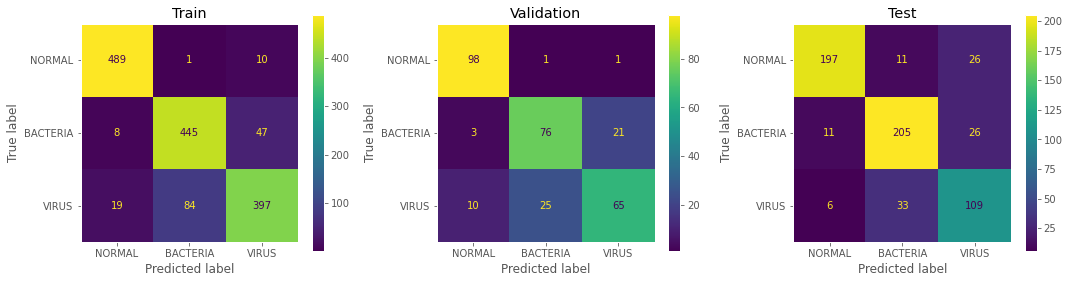

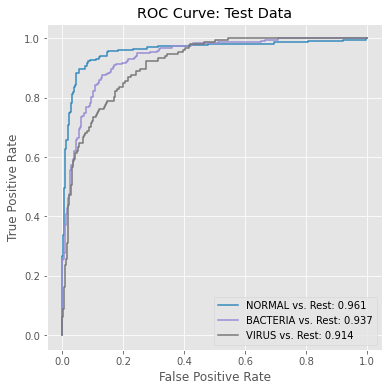

In [626]:
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Things I can adjust to improve the model:

Change input:
Change size of input image
Change number of input images used

Change architecture:
Add/subtract layers
Increase number of filters/nodes in a layer
Change optimizer

Model:
Change number of epochs
Change batch size

Regularization:
Add kernel regularization
Add dropout layers